## Libraries

Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans

## Part1: Exploratory Data Analysis

Read the data and familiarize with the data

In [2]:
df = pd.read_csv("customer_segmentation_data.csv", sep=',', index_col = False)
df.head()

,minutes_watched,CLV,region,channel
0,3197.0,205.42,2,4
1,63.0,149.99,0,1
2,605.0,119.00,2,2
3,20.0,240.00,2,4
4,245.0,184.36,1,4


The dataset contains four columns. First column is student's overall engagement in `minutes_watched`. Second column is `CLV` i.e., customer lifetime value. Third column is geographical `region`, where the mapping is as follows:

| Value | Region | 
|-------|---------------------------|
| 0     | US, Canada, UK, Australia | 
| 1     | Western Europe | 
| 2     | Rest of the world | 

Last column is `channel` - contains results from the survey question: "How did you hear about us?" The mapping for this columns is as follows:

| Value | channel | 
|-------|-----------|
| 1     | Google | 
| 2     | Facebook | 
| 3     | YouTube |
| 4     | LinkedIn |
| 5     | Twitter |
| 6     | Instagram |
| 7     | Friend |
| 8     | Other |

In [3]:
df.describe()

,minutes_watched,CLV,region,channel
count,3725.000000,3834.000000,3834.000000,3834.000000
mean,1972.094497,118.383920,1.167188,3.870370
std,7401.693028,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,159.000000,62.580000,0.000000,2.000000
50%,512.000000,119.000000,2.000000,3.000000
75%,1521.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


In [4]:
# Make a copy of the original dataframe
df_segmentation = df.copy()

In [5]:
# Check for missing values
df_segmentation.isnull().sum()

minutes_watched    109
CLV                  0
region               0
channel              0
dtype: int64

In `minutes_watched` category, there are 109 missing values. we will fill those empty values with zeroes for our analysis.

In [6]:
# Fill the missing values with zeroes
df_segmentation = df_segmentation.fillna(0)

In [7]:
df_segmentation.dtypes

minutes_watched    float64
CLV                float64
region               int64
channel              int64
dtype: object

### Correlation Estimate

we start by estimating the correlation index between the variables

In [8]:
correlation_matrix = df_segmentation.corr()

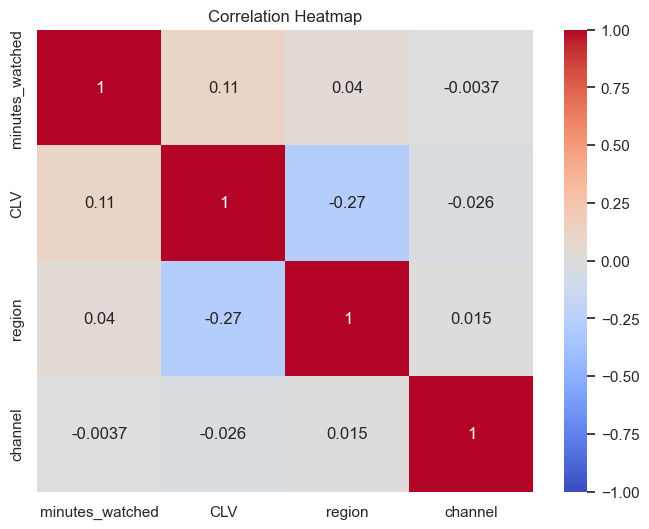

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(data = correlation_matrix,
           annot = True,
           cmap = 'coolwarm',
           vmin = -1,
           vmax = 1)
plt.title('Correlation Heatmap')
plt.savefig('correlation.png')
plt.show()

This analysis does not reveal strong or positive correlations within the data. Therefore, I employ more sophisticated learning methods to understand the relationship within the data.

### Visualize Raw Data

Create a scatter plot of the two numerical values in our data: `minutes_watched` and `CLV`

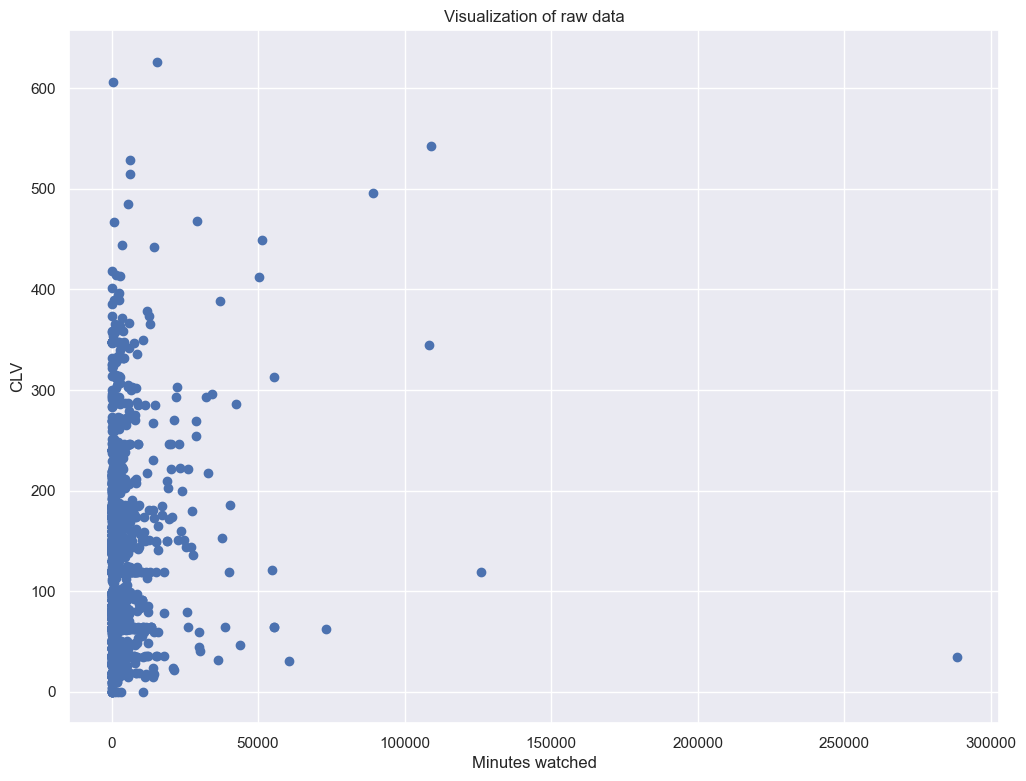

In [10]:
plt.figure(figsize = (12, 9))
plt.scatter(df_segmentation.iloc[:, 0], df_segmentation.iloc[:, 1])
plt.xlabel('Minutes watched')
plt.ylabel('CLV')
plt.title('Visualization of raw data')
plt.savefig('scatter.png')
plt.show()

Minutes_watched vs. CLV plot does not reveal much, apart from noticing a few outliers. Thus, I cannot conclude anything because the scale of the minutes watched vastly differs from that of the CLV. This leaves the chart looking cluttered. A possible solution would be to remove the outliers or rescale the minutes watched to hours watched.

Lastly, this scatter plot serves as an illustrative reminder of a pivotal aspect of our analysis: the importance of uniformly scaling all features to ensure they hold equal weight during segmentation.

## Create Dummy Variables

To perform a quantitative analysis of the groups, I’ll create dummy variables for the region of countries and the channels - the survey answers. These are categorical answers, so having them as dummy variables makes sense.

In [11]:
# Create a list of the channels of acquisition variable
df_channels = df_segmentation['channel']

In [12]:
# Create a list of the geographic regions variable
df_countries = df_segmentation['region']

In [13]:
# Get dummy variables for each unique value in 'channel' using pandas function
df_dummies = pd.get_dummies(df['channel'].apply(pd.Series).stack()) # df['channel'].apply(pd.Series).stack() reshapes the DataFrame df['channel'] into a Series, applies the pd.Series function to split the values into separate columns, and then stacks them into a single column.

# Use groupby on index and then sum the results
df_dummies = df_dummies.groupby(level=0).sum() # groups the dummy variables by the index level and aggregates the dummy variables by summing them up for each group

# Join the dummy variables to original dataframe
df = df.join(df_dummies)

In [14]:
# Creating dummy variables for the `df_channels` dataframe. 
segment_dummies = pd.get_dummies(df_channels, prefix = 'channel', prefix_sep = '_')

# Appending the created dummy columns from `segment_dummies` to the `df_segmentation` dataframe.
df_segmentation = pd.concat([df_segmentation, segment_dummies], axis = 1)

In [15]:
# Creating dummy variables for the `df_countries` dataframe. 
# Each column in `df_countries` will be prefixed with 'country_region_' in the new columns.
segment_dummies_2 = pd.get_dummies(df_countries, prefix = 'country_region', prefix_sep = '_')

# Appending the created dummy columns from `segment_dummies_2` to the `df_segmentation` dataframe.
df_segmentation = pd.concat([df_segmentation, segment_dummies_2], axis = 1)

In [16]:
# drop the channel variable as it is non-numerical and we'll not be able to perform the segmentation
df_segmentation = df_segmentation.drop(["channel"], axis = 1)

In [17]:
df_segmentation

,minutes_watched,CLV,region,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,country_region_0,country_region_1,country_region_2
0,3197.0,205.42,2,False,False,False,True,False,False,False,False,False,False,True
1,63.0,149.99,0,True,False,False,False,False,False,False,False,True,False,False
2,605.0,119.00,2,False,True,False,False,False,False,False,False,False,False,True
3,20.0,240.00,2,False,False,False,True,False,False,False,False,False,False,True
4,245.0,184.36,1,False,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,0,False,False,True,False,False,False,False,False,True,False,False
3830,28.0,79.00,0,False,True,False,False,False,False,False,False,True,False,False
3831,57.0,36.00,2,False,True,False,False,False,False,False,False,False,False,True
3832,44.0,36.00,2,True,False,False,False,False,False,False,False,False,False,True


In [18]:
# rename the columns after adding the dummie variables
df_segmentation = df_segmentation.rename(columns = {'channel_1':'Google', 'channel_2':'Facebook', 'channel_3':'YouTube','channel_4':'LinkedIn', 
                                                    'channel_5':'Twitter', 'channel_6':'Instagram', 'channel_7':'Friend', 'channel_8':'Other',
                                                    'country_region_0':'Region_0','country_region_1':'Region_1','country_region_2':'Region_2'})

In [19]:
df_segmentation

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2
0,3197.0,205.42,2,False,False,False,True,False,False,False,False,False,False,True
1,63.0,149.99,0,True,False,False,False,False,False,False,False,True,False,False
2,605.0,119.00,2,False,True,False,False,False,False,False,False,False,False,True
3,20.0,240.00,2,False,False,False,True,False,False,False,False,False,False,True
4,245.0,184.36,1,False,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,0,False,False,True,False,False,False,False,False,True,False,False
3830,28.0,79.00,0,False,True,False,False,False,False,False,False,True,False,False
3831,57.0,36.00,2,False,True,False,False,False,False,False,False,False,False,True
3832,44.0,36.00,2,True,False,False,False,False,False,False,False,False,False,True


## Part 2: Model Implementation

### Data Standardization:

Given such a difference in magnitude regarding `minutes_watched` vs `CLV` from the plot, the data must be standardize before employing the hierarchical and k-means clustering techniques. Without it, the result will likely be unreliable or skewed.

In [20]:
# Initializing a StandardScaler object to standardize the features
scaler = StandardScaler()

# Standardizing the data in the 'df_segmentation' dataframe.
# This means transforming the data so that it has a mean of 0 and a standard deviation of 1 for each feature.
segmentation_std = scaler.fit_transform(df_segmentation)
segmentation_std

array([[ 0.17542513,  1.23521866,  0.90235187, ..., -0.74396546,
        -0.36969391,  0.95410372],
       [-0.25376647,  0.44855443, -1.26464912, ...,  1.34414843,
        -0.36969391, -1.04810408],
       [-0.17954125,  0.00874342,  0.90235187, ..., -0.74396546,
        -0.36969391,  0.95410372],
       ...,
       [-0.25458815, -1.16919507,  0.90235187, ..., -0.74396546,
        -0.36969391,  0.95410372],
       [-0.25636846, -1.16919507,  0.90235187, ..., -0.74396546,
        -0.36969391,  0.95410372],
       [-0.26239413, -0.55893778, -1.26464912, ...,  1.34414843,
        -0.36969391, -1.04810408]])

### Hierarchical Clustering:

After the data standardization is complete, I start hierarchical clustering using linkage package from scipy.cluster.hierarchy with ward's method. The 'ward' method minimizes the sum of squared differences within all clusters.

In [21]:
hierarchical_clustering = linkage(segmentation_std, method='ward')

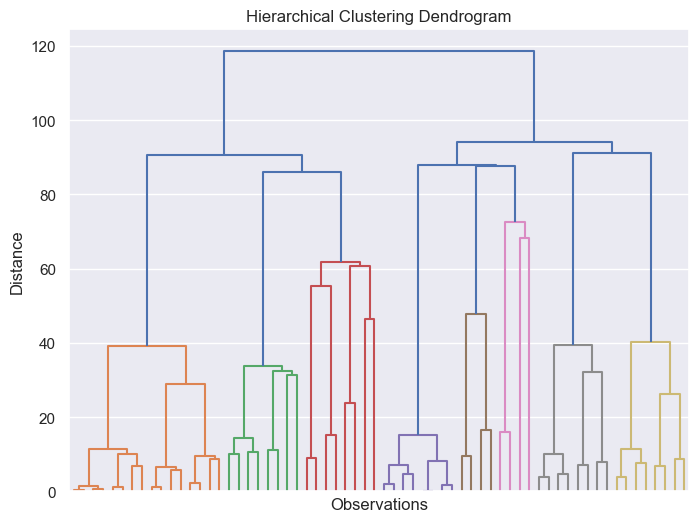

In [22]:
# Visualizatino using matplotlib
plt.figure(figsize=(8, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hierarchical_clustering, truncate_mode='level', p=5, show_leaf_counts=False, no_labels=True)
plt.savefig('hierarchical.png')
plt.show()

The dendrogram points to eight separate clusters.

### K-means clustering:

This is another clustering method. I perform an iteration with 10 k-values utilizing the k-means++ as the initializer. 

In [23]:
inertia = [] # sum of squared distances to the nearest cluster center
means = []
k_values = range(1, 11) # change the range of k_values for more clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(segmentation_std)
    
    means.append(k)
    inertia.append(kmeans.inertia_)

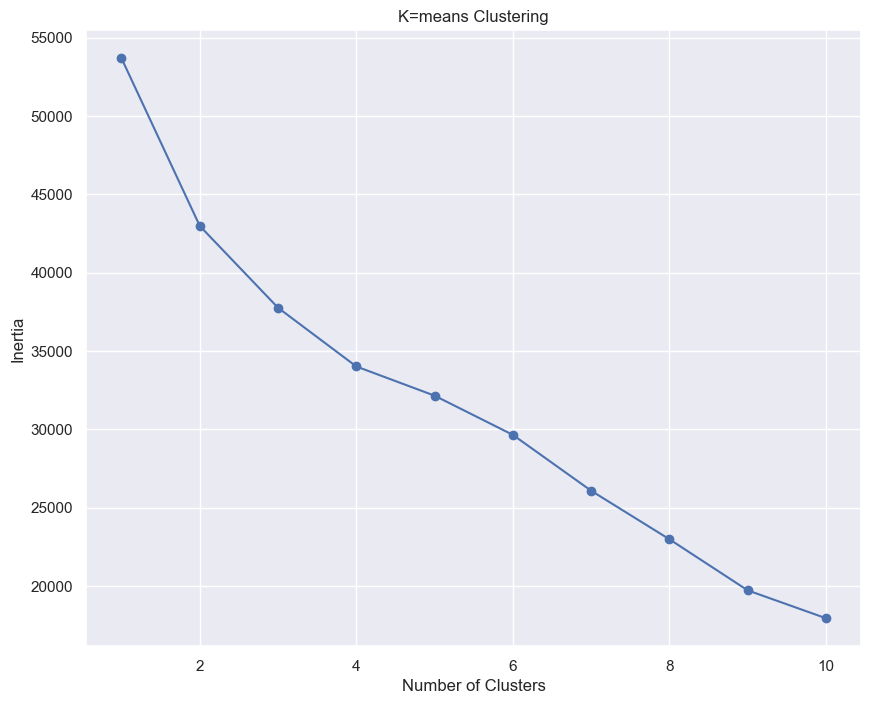

In [24]:
# Generate the elbow plot
plt.figure(figsize=(10, 8))
plt.title('K=means Clustering')
plt.plot(means, inertia, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.savefig('elbow')
plt.show()

Based on above elbow plot, we observe that the results of the K-means point to two, four, or nine different clusters. These results differ from the eight clusters found by the Hierarchical clustering.

**Analysing the results:** K-means and Hierarchical clustering might suggest different numbers of clusters because of the following reasons:

* **Different methodologies:** Hierarchical clustering builds a tree (or dendrogram) of clusters by successively splitting or merging them. The decision to split or merge can be based on various algorithms and criteria. On the other hand, k-means tries to find a predetermined number of clusters (k) that minimizes the within-cluster variance.

* **Initial setup sensitivity:** K-means is highly sensitive to initial starting conditions—i.e., the initial placement of the centroid of each cluster. Different runs give different results. Hierarchical clustering is deterministic and will always provide the same result with the same data.

* **Cluster shape:** K-means works best with spherical and evenly sized clusters. It might not do a good job if the clusters have irregular shapes, varying sizes, or densities. Hierarchical clustering does not have these assumptions.


In this case, I opt for the hierarchical clustering results because it can determine the number of clusters, then apply them in the k-means - i.e., perform K-means clustering with eight clusters and analyze the resulting clusters using a summary table.